In [1]:
!pip install nltk==3.5
!pip install gensim
!pip install umap-learn
!pip install wikipedia
!pip install unidecode

     |████████████████████████████████| 1.4 MB 7.2 MB/s 
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434691 sha256=526a2a973ba1495ffc287be29a31ff96d425e0a8db066959c74705074357129b
  Stored in directory: /root/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 86 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 16.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=fe0e1248a4e52298e4f97d74261a035d375afa4f586d0411bff3e97e00b036f1
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=79359e6455852d47c0e4d64acfe1f89dcc2e995030a5bf39

In [54]:
import re
import nltk
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.corpus import stopwords
import wikipedia
import string
from unidecode import unidecode
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import urllib.request
import bz2
import gensim
import warnings
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Definição do Corpus

## Base

In [3]:
wikipedia.set_lang("pt")
bh = wikipedia.page("Belo Horizonte")

In [4]:
corpus = bh.content

Selecionamos algumas frases do corpus de BH da wikipedia.

Conside a lista abaixo como nosso corpus de documentos. Cada elemento da lista, considere como um único documento.

In [5]:
documentos = \
["Belo Horizonte é um município brasileiro e a capital do estado de Minas Gerais",
"A populacao de Belo Horizonte é estimada em 2 501 576 habitantes, conforme estimativas do Instituto Brasileiro de Geografia e Estatística",
"Belo Horizonte já foi indicada pelo Population Crisis Commitee, da ONU, como a metrópole com melhor qualidade de vida na América Latina",
"Belo Horizonte é mundialmente conhecida e exerce significativa influência nacional e até internacional, seja do ponto de vista cultural, econômico ou político",
"Belo Horizonte é a capital do segundo estado mais populoso do Brasil, Minas Gerais"]

## Preprocessamento

<b> Atividade </b>

1) Escreva uma método que realiza o pré-processamento da lista de <b>documentos</b>.

O método deve, para cada documento:
- tokenizar cada palavra
- remover stopwords
- remover números
- remover pontuções
- remover acentos

In [6]:
def pre_processamento_texto(corpus):
  print("Documento")
  print("#tokenizacao")
  corpus_alt = re.findall(r"\w+(?:'\w+)?|[^\w\s]",corpus)
  #lowcase
  corpus_alt = [t.lower() for t in corpus_alt]
  print("remove stopwords")
  portuguese_stops = stopwords.words('portuguese')
  corpus_alt = [t for t in corpus_alt if t not in portuguese_stops]
  print("remove numeros")
  corpus_alt = [re.sub(r'\d','',t) for t in corpus_alt]
  print("remove pontuação")
  corpus_alt = [t for t in corpus_alt if t not in string.punctuation]
  print("remove acentos")
  corpus_alt = [unidecode(t) for t in corpus_alt]

  return corpus_alt

In [7]:
documentos_pre_processados = [pre_processamento_texto(frase) for frase in documentos]

Documento
#tokenizacao
remove stopwords
remove numeros
remove pontuação
remove acentos
Documento
#tokenizacao
remove stopwords
remove numeros
remove pontuação
remove acentos
Documento
#tokenizacao
remove stopwords
remove numeros
remove pontuação
remove acentos
Documento
#tokenizacao
remove stopwords
remove numeros
remove pontuação
remove acentos
Documento
#tokenizacao
remove stopwords
remove numeros
remove pontuação
remove acentos


# Representação Textual

### Phrases - Gensim

Forma mais inteligente de calcular os bigrams. Ela calcula os bigramas levando em consideração a frequência do par das palavaras em todos os documentos.
Para isso ele treina um modelo e depois aplica no corpus.

```python
#treinamento bigrams
model_corpus_phrases = gensim.models.Phrases(corpus_processado, min_count=1)
#calulando os bigrams do corpus processado
bigram_corpus = model_corpus_phrases[corpus_processado]
```

<b> Atividade </b>

2) Faça um código que treine os bigrams, sendo que o <b>min_count = 1</b>. 
O <b>min_count</b> é a contagem mínima que aquele par de palavras deve aparecer junto para considerarmos com um token. Teste também com outros valores de mim_count. Depois imprima os bigramas de cada documento.
Use o corpus_processado.

In [8]:
# treinamento bigrams
model_corpus_phrases = gensim.models.Phrases(documentos_pre_processados, min_count=1)
# calulando os bigrams do corpus processado
bigram_corpus = model_corpus_phrases[documentos_pre_processados]

## TD-IDF

Dica de leitura: https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.XklQxnVKj7c

Para representar o texto com TF-IDF utilizamos o TfidfVectorizer. A seguir apresentamos instruções sobre como utilizá-lo.

```python
#primeiro criamos o objeto
vect = TfidfVectorizer()
vect #aqui você pode observa todos os parâmetros que o objeto possui
## Existem alguns parâmetros, opcionais, que podemos informar para uma possível melhora do nosso modelo. Por exemplo:
### inclui 1-grams e 2-grams
vect.set_params(ngram_range=(1, 2))
### ignora termos que a aparecem em mais de 50% dos documentoss
vect.set_params(max_df=0.5)
### só considero termos que aparecem em ao menos 2 documentos
vect.set_params(min_df=2)

#depois aplicamos fit_transform para transformar o texto em números
docs_tdidf = vect.fit_transform(docs)

#o docs_tdidf é uma matriz com os números que representam cada um dos textos. 
## Conseguimos verificar a dimensão desta matriz:
print(docs_tdidf.shape)

#Para visualizar as features capturadas pelo TF-IDF utilize:
print(vect.get_feature_names())
#Para visualizar os vetores correspondentes a cada palavara utilize:
df = pd.DataFrame(docs_tdidf.T.todense(), index=vect.get_feature_names(), columns=["doc"+str(i+1) for i in range(0,len(docs))])
df
```

<b> Atividade: </b>

3) Faça o TDIFTVectorizer nos documentos da variável <b>documentos</b> sem alterar nenhum parâmetro. 

In [9]:
# primeiro criamos o objeto
vect = TfidfVectorizer()
vect #aqui você pode observa todos os parâmetros que o objeto possui
## Existem alguns parâmetros, opcionais, que podemos informar para uma possível melhora do nosso modelo. Por exemplo:
### inclui 1-grams e 2-grams
vect.set_params(ngram_range=(1, 2))
### ignora termos que a aparecem em mais de 50% dos documentoss
vect.set_params(max_df=0.5)
### só considero termos que aparecem em ao menos 2 documentos
vect.set_params(min_df=2)

# depois aplicamos fit_transform para transformar o texto em números
docs_tfidf = vect.fit_transform(documentos)

<b> Atividade </b>

4) Imprima o shape do resultado da atividade 4

In [10]:
print(docs_tfidf.shape)

(5, 7)


<b> Atividade </b>

5) Imprima as features capturadas em 4.

In [11]:
print(vect.get_feature_names())

['brasileiro', 'capital', 'capital do', 'estado', 'gerais', 'minas', 'minas gerais']


6) Imprima os vetores correspondentes a cada palavra de cada documento.

In [12]:
df = pd.DataFrame(docs_tfidf.T.todense(), index=vect.get_feature_names(), columns=["doc"+str(i+1) for i in range(0,len(documentos))])
df

,doc1,doc2,doc3,doc4,doc5
brasileiro,0.377964,1.0,0.0,0.0,0.000000
capital,0.377964,0.0,0.0,0.0,0.408248
capital do,0.377964,0.0,0.0,0.0,0.408248
estado,0.377964,0.0,0.0,0.0,0.408248
gerais,0.377964,0.0,0.0,0.0,0.408248
minas,0.377964,0.0,0.0,0.0,0.408248
minas gerais,0.377964,0.0,0.0,0.0,0.408248


## Bag of Words

Para representar o bag of words utilizamos o CountVectorizer

```python
#primeiro criamos o objeto
vect_bag = CountVectorizer(binary=True) #se binary = False -> ocorre a contagem da frequência em que a palavra aparece
vect_bag #imprime os parâmetros

```

<b> Atividade </b>

7) Faça o CountVectorizer nos documentos da variável <b>documentos</b> considerando binary = True

In [13]:
vect_bag = CountVectorizer(binary=True) #se binary = False -> ocorre a contagem da frequência em que a palavra aparece
vect_bag
vect_bow = vect_bag.fit_transform(documentos)


In [14]:
vect_bow.todense()

matrix([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
         1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
         1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 

<b> Atividade </b>

8) Imprima o índice correspondente a cada token da lista retornada por vect_bag.get_feature_names()

In [15]:
print(vect_bag.get_feature_names())

['501', '576', 'américa', 'até', 'belo', 'brasil', 'brasileiro', 'capital', 'com', 'commitee', 'como', 'conforme', 'conhecida', 'crisis', 'cultural', 'da', 'de', 'do', 'econômico', 'em', 'estado', 'estatística', 'estimada', 'estimativas', 'exerce', 'foi', 'geografia', 'gerais', 'habitantes', 'horizonte', 'indicada', 'influência', 'instituto', 'internacional', 'já', 'latina', 'mais', 'melhor', 'metrópole', 'minas', 'mundialmente', 'município', 'na', 'nacional', 'onu', 'ou', 'pelo', 'político', 'ponto', 'populacao', 'population', 'populoso', 'qualidade', 'segundo', 'seja', 'significativa', 'um', 'vida', 'vista']


In [16]:
pd.DataFrame(vect_bow.todense().T, index=vect_bag.get_feature_names()).T

,501,576,américa,até,belo,brasil,brasileiro,capital,com,commitee,como,conforme,conhecida,crisis,cultural,da,de,do,econômico,em,estado,estatística,estimada,estimativas,exerce,foi,geografia,gerais,habitantes,horizonte,indicada,influência,instituto,internacional,já,latina,mais,melhor,metrópole,minas,mundialmente,município,na,nacional,onu,ou,pelo,político,ponto,populacao,population,populoso,qualidade,segundo,seja,significativa,um,vida,vista
0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
3,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,1
4,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


## Embedding

### Utilizando um embedding treinado

<b> Atividade </b>

9) Faça download do seguinte arquivo, realize a leitura deste arquivo e carregue o modelo: 
https://drive.google.com/file/d/1f5sNZcV8LDam4zxbHnkm472r3r8D_UpX/view?usp=sharing

Depois suba no seu drive e carregue,

obs.: como o embedding é pesado, demora um pouco para carregar, cerca de 4 minutos.

In [17]:
#opção 1 -> montar o drive no colab e acessar o arquivo de embedding do drive
from google.colab import drive
drive.mount('/content/drive')

#opção 2 -> fazer download e fazer upload por aqui
#from google.colab import files
#uploaded = files.upload()

Mounted at /content/drive


In [18]:
%%time
# carregar
##na variável path coloque o caminho do embedding baixado:
path = "/content/drive/MyDrive/Pós-Graduação/PLN/ptwiki_20180420_100d.txt.bz2"
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(path, binary=False)

CPU times: user 2min 19s, sys: 1.29 s, total: 2min 21s
Wall time: 2min 23s


<b> Atividade </b>

10) Imprima os vetores das palavras "nlp" e "computacao"

```python
#exemplo de retorno do vetor
word_vectors[__]
```

In [19]:
print("nlp: ", word_vectors["nlp"])
print("computacao: ", word_vectors["computacao"])


nlp:  [ 0.8528  0.1094 -0.0296 -0.0458 -0.2029 -0.1839 -0.2012 -0.111  -0.0315
  0.1895 -0.2194 -0.3496 -0.1319 -0.1594  0.1549 -0.493   0.1897 -0.296
  0.0026  0.2015  0.0215  0.2946 -0.2024  0.3931  0.143   0.0667 -0.4868
  0.048  -0.1028  0.2372  0.2042 -0.8025 -0.1221  0.475  -0.2997  0.219
  0.1232 -0.2118  0.5402 -0.0768  0.2253  0.1285 -0.6157  0.1777  0.0306
 -0.1094 -0.1649 -0.386  -0.2692  0.3149  0.0391 -0.0821 -0.2238  0.033
  0.5032  0.0836  0.1834 -0.2009 -0.0722 -0.1744  0.3946 -0.0792 -0.0863
  0.3813  0.5876 -0.4447 -0.5435  0.1528 -0.1012 -0.0967 -0.2621  0.4737
  0.3235 -1.1013 -0.0789  0.1945 -0.1304 -0.0379  0.899   0.0398  0.2908
 -0.4276 -0.0641 -0.3841  0.354   0.4139  0.1076 -0.3439 -0.1474 -0.1215
  0.4359 -0.1563  0.2577  0.4333  0.2003 -0.4064 -0.818   0.0812 -0.2554
 -0.48  ]
computacao:  [ 0.5076 -0.2598  0.0993  0.1021 -0.2076 -0.2745  0.0104  0.0107  0.0151
  0.2485 -0.2933  0.1184 -0.4087 -0.0381  0.0528 -0.2312  0.1387  0.1144
  0.0291  0.164  -0.0941 

<b> Similaridade de Vetores </b> 

No gensim é possível realizar a similaridade utilizando o seguinte método:

```python
word_vectors.most_similar(___)
```

<b> Atividade </b>

11) Verifique a similaridade das seguintes palavras: elizabete, raiva, segunda, dois, computação.

In [20]:
print("elizabete:",word_vectors.most_similar("elizabete"))
print("raiva:",word_vectors.most_similar("raiva"))
print("segunda:",word_vectors.most_similar("segunda"))
print("dois:",word_vectors.most_similar("dois"))
print("computação:",word_vectors.most_similar("computação"))

elizabete: [('joana', 0.7828384041786194), ('elídia', 0.7808018922805786), ('arcângela', 0.7692556381225586), ('maria', 0.7659809589385986), ('felisbela', 0.7649518847465515), ('andreza', 0.7636873722076416), ('thomazia', 0.7636217474937439), ('francisca', 0.7602137327194214), ('eleonora', 0.7596681118011475), ('deodata', 0.7594977617263794)]
raiva: [('medo', 0.8303433656692505), ('frustração', 0.8079831600189209), ('desespero', 0.8039345741271973), ('tristeza', 0.800615668296814), ('remorso', 0.7922823429107666), ('desgosto', 0.7901228666305542), ('inveja', 0.781806468963623), ('ciúmes', 0.7798185348510742), ('ódio', 0.776374101638794), ('repugnância', 0.7657582759857178)]
segunda: [('primeira', 0.8965903520584106), ('quarta', 0.8717238903045654), ('terceira', 0.8408156037330627), ('última', 0.8141331672668457), ('sétima', 0.807178258895874), ('sexta', 0.7998778820037842), ('décima', 0.7983245849609375), ('penúltima', 0.7719092965126038), ('nona', 0.7675511240959167), ('oitava', 0.767

elizabete<b> Operação Vetorial</b>

Na aula teórica, estudamos sobre as operação entre os vetores. 
Agora vamos ver na prática:

```python
#exemplo:
word_vectors.wv.most_similar(positive=['mulher', 'rei'], negative=['homem'], topn=10)
```

<b>Atividade</b>

12) Execute o exemplo acima em uma célula e repita para os seguintes cenários:

- menino, menina, homem
- caminhada, andar, correr
- filho, filha, irmã
- pai, mãe, avô

<b> Reflita </b> as palavras similares fazem sentido?

In [21]:
print(word_vectors.wv.most_similar(positive=['menino', 'menina'], negative=['homem'], topn=10))
print(word_vectors.wv.most_similar(positive=['caminhada', 'andar'], negative=['correr'], topn=10))
print(word_vectors.wv.most_similar(positive=['filho', 'filha'], negative=['irmã'], topn=10))
print(word_vectors.wv.most_similar(positive=['pai', 'mãe'], negative=['avô'], topn=10))


[('garotinha', 0.746025800704956), ('criança', 0.7124738693237305), ('izildinha', 0.6914386749267578), ('garota', 0.6765151619911194), ('órfã', 0.6759505271911621), ('filhinha', 0.6749870777130127), ('avó', 0.6711723804473877), ('babá', 0.6623851656913757), ('irmãzinha', 0.6621854305267334), ('moça', 0.6594897508621216)]
[('caminhadas', 0.618974506855011), ('pavimento', 0.606018602848053), ('passeio', 0.6024052500724792), ('piquenique', 0.598796546459198), ('sala', 0.5944793224334717), ('terraço', 0.5920617580413818), ('rampa', 0.5885153412818909), ('passarela', 0.5874667167663574), ('climatizada', 0.5863767862319946), ('calçadão', 0.5852184295654297)]
[('bisneto', 0.851236879825592), ('neto', 0.8316095471382141), ('primogênito', 0.8290099501609802), ('bisavô', 0.822635293006897), ('sobrinho', 0.8176089525222778), ('avô', 0.816977858543396), ('sogro', 0.8009151220321655), ('pai', 0.799014687538147), ('primogénito', 0.785844624042511), ('genro', 0.7755304574966431)]
[('avó', 0.815079092

In [22]:
#As palavras respostas fazem sentido pois de certo modo estão relacionadas com as palavras passadas como entrada 

### Treinando seu embedding

Aqui vamos utilizar o corpus machado. São textos/contos escritos por Machado de Assis.
Esse corpus é diponibilizado pelo NLTK.

In [23]:
from nltk.corpus import machado

In [24]:
import nltk
from nltk.corpus import machado
nltk.download('punkt')
nltk.download('machado')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package machado to /root/nltk_data...


True

In [25]:
raw_casmurro = machado.raw('contos/macn001.txt')

O método ''machado_sents()'' retorna todo o texto quebrado pelas setenças e já tokenizado.

As sentenças são separadas pelo "\n". Dentro de cada sentença, divide os tokens separadas pelo espaço.

In [26]:
machado_sents = machado.sents()
print(machado_sents)

[['Conto', ',', 'Contos', 'Fluminenses', ',', '1870'], ['Contos', 'Fluminenses'], ...]


Vamos relizar um pré-processamento mínimo nos dados. Lembrando que: o pré-processamento é impotatíssimo no resultado final.

<b> Atividade </b>

13) Aplique as técnicas abaixo no documento <b> machado_sents</b>: 

- lower
- remoção pontuações

In [27]:
%%time 
texto_machado_limpo = [ [palavra.lower() for palavra in sentenca if palavra not in string.punctuation] for sentenca in machado_sents]
texto_machado_limpo

CPU times: user 11.4 s, sys: 269 ms, total: 11.6 s
Wall time: 11.6 s


In [28]:
texto_machado_limpo[0]

['conto', 'contos', 'fluminenses', '1870']

<b> Treinando o embedding </b> 

Para treinar os embeddings existem alguns parâmetros, vide exemplo abaixo:

```python
#Alguns parâmetros:
## size -> dimensão vetor
## min_count -> ignora todas palavras cuja frequência mínima é menor que este
## workers -> quantas threads serão utilizadas para treinar o modelo
## seed -> seed para geração do numero aleatório. 
## sg -> 1 para skip-gram; caso contrário CBOW.
## window -> contexto, Distância máxima entre a palavra atual e a prevista em uma frase. O default é 5.
model = word2vec.Word2Vec(text_preproc, min_count=10, workers=4, seed=123, sg=1, size=300, window=5)
```

<b> Atividade </b>

14) Gere os embeddings com o texto processado do documento de Machado de Assis.


In [29]:
model = word2vec.Word2Vec(texto_machado_limpo, min_count=10, workers=4, seed=123, sg=1, size=300, window=5)



<b> Atividade </b>

15) Faça os itens abaixo:

- Verifique o vetor de embeddings da variável "dom"
- Verifique a similaridade entre "mulher" e "homem"
- Verifique a similaridade entre "dom" e "casmurro"

In [30]:
print(model["dom"])
print(model["dom"].shape)

[ 2.81130169e-02  6.22368604e-02 -1.05532520e-01  6.33088648e-02
  8.60319808e-02 -2.79095583e-02 -4.07151505e-02  1.01635411e-01
  1.89305127e-01 -6.45595044e-02 -2.25485228e-02  3.36854346e-02
  2.36442268e-01  2.31494442e-01 -3.44652683e-02  5.59320003e-02
  5.04081286e-02  2.83032916e-02 -1.81595609e-01  6.72265980e-03
  6.08069673e-02  3.18789035e-02  1.10426925e-01  7.43197426e-02
  2.82093119e-02 -2.76626628e-02  7.66484216e-02 -8.82800967e-02
  8.85807052e-02 -2.35511988e-01  9.63529348e-02 -1.15038253e-01
 -7.68657774e-02  1.94098800e-02  4.06796820e-02 -1.16190359e-01
 -1.81068089e-02 -1.83733791e-01 -1.90165997e-01 -1.55584976e-01
 -2.65013576e-01  1.06080890e-01 -1.32576585e-01 -1.08114272e-01
 -1.04971536e-01  3.76361273e-02  1.49117991e-01  8.61570332e-03
 -1.99578375e-01  1.74757428e-02 -1.34750813e-01  6.69038370e-02
 -1.34766459e-01  9.43898782e-03  1.31926477e-01 -1.58334896e-01
 -1.22813150e-01 -5.17066568e-02 -4.34162980e-03  1.57822728e-01
  2.69730967e-02 -9.49096

In [31]:
print("Similaridade mulher e homem: ",model.similarity("mulher","homem"))
print("Similaridade dom e casmurro: ",model.similarity("dom","casmurro"))

Similaridade mulher e homem:  0.4193292
Similaridade dom e casmurro:  0.6784538


<b> Salvando o modelo</b>

In [32]:
model.wv.save_word2vec_format('model_TESTE.bin', binary=True)

<b> Atividade </b>

Dada as seguintes palavras:

foi, relógio, amor, raiva, brasil.

16) Escreva um método que retorne uma lista com as 5 palavras similares de cada uma das listadas anteriormente.
Imprima a lista das palavras similares, incluindo a palavra origem.

In [33]:
similiar_foi = model.most_similar("foi",topn=5)
similiar_relogio = model.most_similar("relógio",topn=5)
similiar_amor = model.most_similar("amor",topn=5)
similiar_raiva = model.most_similar("raiva",topn=5)
similiar_brasil = model.most_similar("brasil",topn=5)

print("Similaridade 'foi': ", similiar_foi)
print("Similaridade 'relógio': ", similiar_relogio)
print("Similaridade 'amor': ", similiar_amor)
print("Similaridade 'raiva': ", similiar_raiva)
print("Similaridade 'brasil': ", similiar_brasil)

Similaridade 'foi':  [('fui', 0.5556420087814331), ('correu', 0.5340918898582458), ('serviu', 0.5338103771209717), ('seguiu', 0.5236458778381348), ('obteve', 0.5061323642730713)]
Similaridade 'relógio':  [('embrulho', 0.7494984269142151), ('sapato', 0.7360186576843262), ('revólver', 0.728304386138916), ('paletó', 0.7176345586776733), ('charuto', 0.7137769460678101)]
Similaridade 'amor':  [('ciúme', 0.6950008869171143), ('orgulho', 0.6633248329162598), ('arrependimento', 0.6564425230026245), ('casto', 0.6364181637763977), ('afeto', 0.6355516910552979)]
Similaridade 'raiva':  [('morder', 0.8401992321014404), ('impaciência', 0.8388074636459351), ('mordia', 0.8304884433746338), ('amargura', 0.8156095147132874), ('assobiar', 0.7937184572219849)]
Similaridade 'brasil':  [('município', 0.8018879890441895), ('méxico', 0.7977259159088135), ('cruzeiro', 0.77750563621521), ('maranhão', 0.7724354863166809), ('sul', 0.7698863744735718)]


### Visualização

Para a visualização dos embeddings iremos  construir um array com todas as palavras retornadas anteriormente.

<b> Atividade </b>

17) Primeiro, gere uma única lista com todas as palavras retornadas anteriomente. O array deve ter tamanho 30.

In [34]:
#Professora, tamanho 30? Era pra ser top6 no most_similar então?

In [45]:
all_words = ["foi", "relógio", "amor", "raiva", "brasil"]
[all_words.append(tupla[0]) for tupla in similiar_foi]
[all_words.append(tupla[0]) for tupla in similiar_relogio]
[all_words.append(tupla[0]) for tupla in similiar_amor]
[all_words.append(tupla[0]) for tupla in similiar_raiva]
[all_words.append(tupla[0]) for tupla in similiar_brasil]

all_words

['foi',
 'relógio',
 'amor',
 'raiva',
 'brasil',
 'fui',
 'correu',
 'serviu',
 'seguiu',
 'obteve',
 'embrulho',
 'sapato',
 'revólver',
 'paletó',
 'charuto',
 'ciúme',
 'orgulho',
 'arrependimento',
 'casto',
 'afeto',
 'morder',
 'impaciência',
 'mordia',
 'amargura',
 'assobiar',
 'município',
 'méxico',
 'cruzeiro',
 'maranhão',
 'sul']

18) O código abaixo gera um array com todos os embeddings das palavras anteriores. Este array terá dimensão (30,300)

In [46]:
array_embeddings = np.empty((0,300), dtype='f')
for w in all_words:
    array_embeddings = np.append(array_embeddings, np.array([model[w]]), axis=0)
print(array_embeddings.shape)

(30, 300)


<b>Dica: </b> Use a função abaixo para plotar o array 2D que será gerado com o método PCA, TSNE e UMAP

In [37]:
def plot_embedding_2d(array_2d, all_words, words_seed):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for (x, y), w in zip(array_2d, all_words):
        ax.scatter(x, y, c='red' if w in words_seed else 'blue')
        ax.annotate(w,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

#### PCA

<b> É uma ténica que existe a mais de século. É rápido, determinístico e linear. Essa linearidade limita sua utilidade em domínios complexos, como linguagem natural ou imagens, onde a estrutura não linear. </b>

Mais informações: https://medium.com/towards-artificial-intelligence/machine-learning-dimensionality-reduction-via-principal-component-analysis-1bdc77462831


<b> Atividade </b>

19) Gere a visualização dos embeddings anteriores utilizando o PCA para reduzir a dimensionalidade.

Exemplo do PCA:

```python
#uso de PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(array_embeddings)
```

In [47]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(array_embeddings)
pca_result.shape

(30, 2)

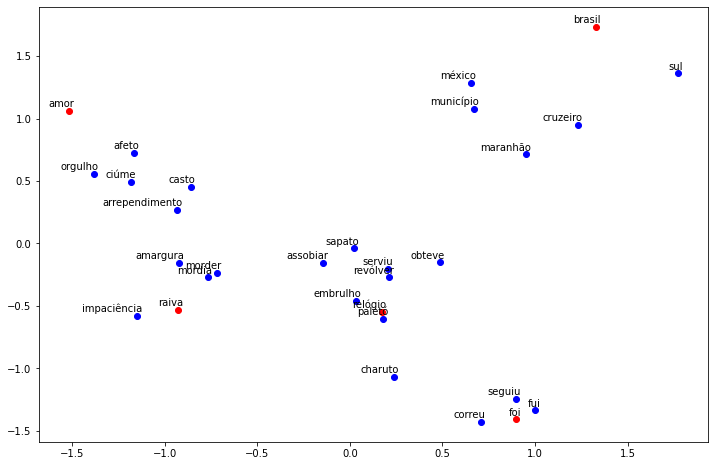

In [48]:
plot_embedding_2d(pca_result,all_words,["foi", "relógio", "amor", "raiva", "brasil"])

#### TSNE
<b> Uma técnica mais recente que captura estrutura não linear é o t-SNE, que significa distribuição estocástica de embedding viziznhos em t ( t-distributed Stochastic Neighbor Embedding). 
É uma ótima técnica para capturar a estrutura não linear em dados de alta dimensão(pelo menos em nível local). Isto é, dois pontos que são próximos no espaço de alta dimensão a probabilidade de estarem próximos em uma dimensão baixa é alta. </b>

Mais informações: https://medium.com/@garora039/dimensionality-reduction-using-t-sne-effectively-cabb2cd519b

<b> Atividade </b>

20) Gere a visualização dos embeddings anteriores utilizando o TSNE para reduzir a dimensionalidade.

Exemplo do TSNE:

```python
#uso de TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=4)
tsne_result =  tsne.fit_transform(array_embeddings)
```

In [49]:
tsne = TSNE(n_components=2, random_state=0, perplexity=4)
tsne_result =  tsne.fit_transform(array_embeddings)
tsne_result.shape

(30, 2)

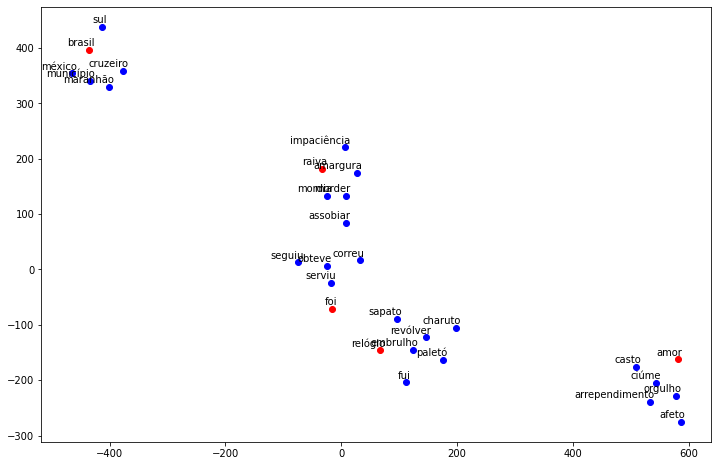

In [52]:
plot_embedding_2d(tsne_result,all_words,["foi", "relógio", "amor", "raiva", "brasil"])

#### UMAP

<b> Técnica super nova!! Foi lançada em 2018! Observe que o resultado do UMAP com o TSNE é semelhante. Mas existem várias vantagens do UMAP, por exemplo: é mais rápido que o t-SNE; ele captura melhor a estrutura global </b>

Mais informações: https://medium.com/@dan.allison/dimensionality-reduction-with-umap-b081837354dd

<b> Atividade </b>

21) Gere a visualização dos embeddings anteriores utilizando o UMAP para reduzir a dimensionalidade.

Exemplo do UMAP:

```python
#uso de TSNE
umap = umap.UMAP()
umap_result =  umap.fit_transform(array_embeddings)
```

In [56]:
umap = umap.UMAP()
umap_result =  umap.fit_transform(array_embeddings)
umap_result.shape

(30, 2)

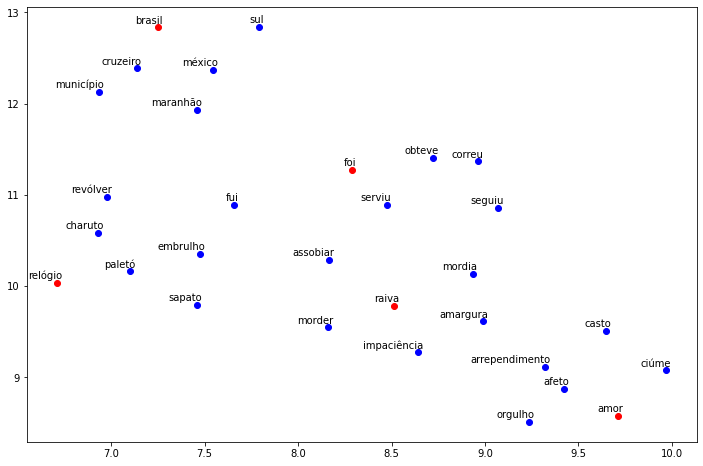

In [57]:
plot_embedding_2d(umap_result,all_words,["foi", "relógio", "amor", "raiva", "brasil"])

In [44]:
# No meu ponto de vista a melhor técnica de visualização foi TSNE